# Q-Learning

🚀 Q-LEARNING EĞİTİMİ BAŞLIYOR (Zorlu Ortam)...
 -> Bölüm 5000/50000 Tamamlandı. (7.9 sn) | Return: -863.3
 -> Bölüm 10000/50000 Tamamlandı. (16.7 sn) | Return: 1446.6
 -> Bölüm 15000/50000 Tamamlandı. (25.1 sn) | Return: 1058.0
 -> Bölüm 20000/50000 Tamamlandı. (33.5 sn) | Return: 237.6
 -> Bölüm 25000/50000 Tamamlandı. (41.7 sn) | Return: 1058.8
 -> Bölüm 30000/50000 Tamamlandı. (50.0 sn) | Return: 1700.0
 -> Bölüm 35000/50000 Tamamlandı. (58.1 sn) | Return: 1191.0
 -> Bölüm 40000/50000 Tamamlandı. (66.0 sn) | Return: 1103.5
 -> Bölüm 45000/50000 Tamamlandı. (74.0 sn) | Return: 1054.2
 -> Bölüm 50000/50000 Tamamlandı. (81.8 sn) | Return: 197.8

✅ EĞİTİM TAMAMLANDI!

📈 Eğitim Grafiği Çiziliyor...


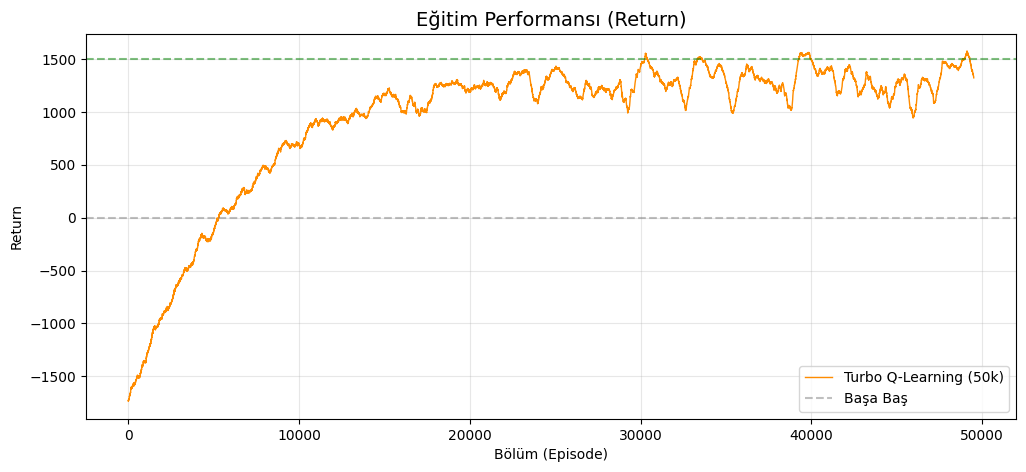


🤖 DETAYLI SİMÜLASYON BAŞLIYOR (50 Adım)

⏱️  ADIM 1 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [IO] | Boyut: 82 br | Süre: 411.3sn | ☕ RAHAT
   👉 SEÇİM:      [CPU] Sunucu 28 (YAVAŞ)
      ✨ Tip Kontrolü: ❌ UYUMSUZ
      ✅ SONUÇ: BAŞARILI. (+50 Puan)
----------------------------------------------------------------------

⏱️  ADIM 2 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [CPU] | Boyut: 56 br | Süre: 68.9sn | 🚨 KRİTİK
   👉 SEÇİM:      [CPU] Sunucu 11 (ORTA)
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. (+45 Puan)
----------------------------------------------------------------------

⏱️  ADIM 3 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [IO] | Boyut: 26 br | Süre: 48.4sn | 🚨 KRİTİK
   👉 SEÇİM:      [IO] Sunucu 31 (HIZLI)
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. (+3 Puan)
----------------------------------------------------------------------

⏱️  ADIM 4 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [CPU] | Boyut: 72 br | Süre: 156.1sn | ⚠️ NORMAL
   👉 SEÇİM:      [CPU] Sunucu 15 (ORTA)


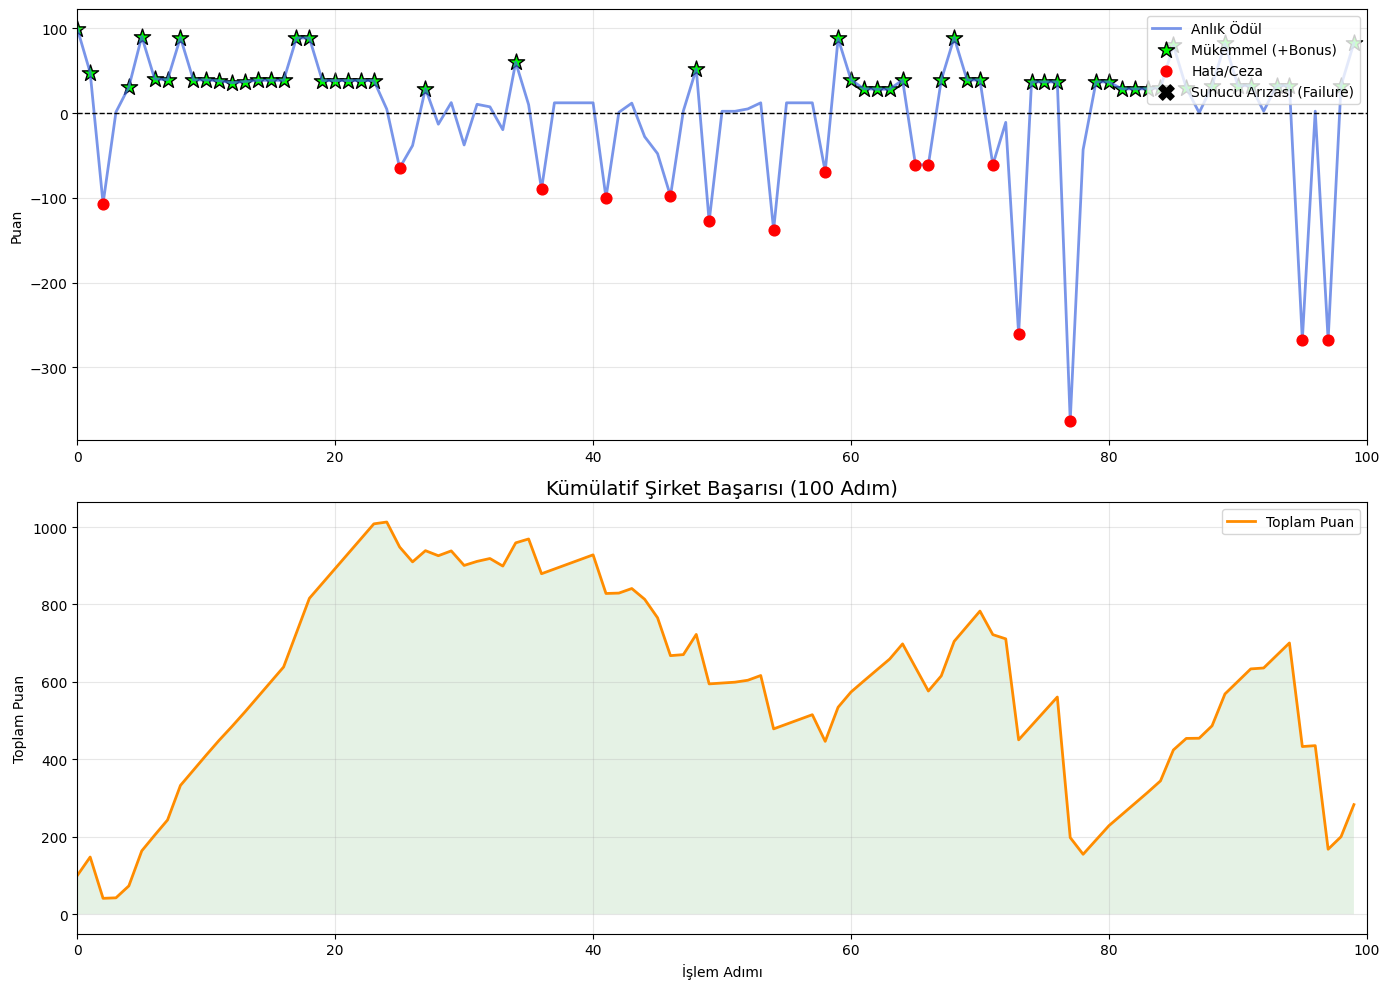

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# ==============================================================================
# 1. ORTAM SINIFLARI
# ==============================================================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type
        self.queue = 0
        self.is_down = False
        self.repair_time = 0
        self.speed_tier = speed_tier

        # Hız ve Maliyet Baz Değerleri
        if speed_tier == 0:   # FAST
            base_speed = 5.0
            base_cost = 12.0
        elif speed_tier == 1: # MID
            base_speed = 2.5
            base_cost = 4.0
        else:                 # SLOW
            base_speed = 1.0
            base_cost = 1.0

        # Tipe Göre Çarpanlar (CPU %50 Daha Hızlı ve Pahalı)
        if s_type == "CPU":
            self.process_speed = base_speed * 1.5
            self.energy_cost = base_cost * 1.5
        else:
            self.process_speed = base_speed * 1.0
            self.energy_cost = base_cost * 1.0

    def do_work(self):
        # Arıza Durumu: Tamir süresini düş, iş yapma
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0:
                self.is_down = False # Tamir bitti
            return 0

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

class OptimizedEnv:
    def __init__(self):
        self.n_servers = 60
        self.servers = []
        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            tier = 0 if (i%30)<10 else (1 if (i%30)<20 else 2)
            self.servers.append(Server(i, s_type, tier))
        self.current_job = self._generate_job()
        self.action_space_n = 60
        self.is_daytime = True

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        size = random.randint(20, 100)
        slack = random.uniform(1.2, 7.0)
        deadline = size / 1.0 * slack
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        j_type = 0 if self.current_job["type"] == "CPU" else 1
        size_bucket = 1 if self.current_job["size"] > 60 else 0
        job_slack = self.current_job["deadline"] / self.current_job["size"]
        if job_slack < 2.0: urgency = 2 # Kritik
        elif job_slack < 4.5: urgency = 1 # Normal
        else: urgency = 0 # Rahat
        price = 1 if self.is_daytime else 0
        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0
        job = self.current_job

        # --- CEZA 1: Bile bile bozuk sunucuya iş atarsa ---
        if target_server.is_down:
            reward -= 50

        # 1. Tahmini Süre ve Bonuslar
        completion_time = (target_server.queue + job["size"]) / target_server.process_speed

        if completion_time <= job["deadline"]:
            reward += 20 # Temel Başarı
            if target_server.speed_tier == 2: reward += 80 # Yavaş Sunucu Bonusu
            elif target_server.speed_tier == 1: reward += 30 # Orta Sunucu Bonusu
        else:
            reward -= 250 # Deadline Kaçırma Cezası

        # 2. İş Ekleme
        target_server.queue += job["size"]

        # --- CEZA 2: Tip Uyuşmazlığı ---
        if target_server.type != job["type"]: reward -= 50

        # 3. Simülasyon (Arıza ve Enerji)
        total_energy = 0
        price_mult = 2.0 if self.is_daytime else 1.0

        for s in self.servers:
            energy = s.do_work()
            total_energy += energy

            # --- CEZA 3: SİSTEMSEL ARIZA (Şanssızlık) ---
            # Olasılık %0.2 (Yüksek Risk)
            if not s.is_down and random.random() < 0.002:
                s.is_down = True
                s.repair_time = 15 # Tamir süresi
                reward -= 100      # Arıza Cezası

        # Enerji Maliyeti Düşülüyor
        reward -= (total_energy * price_mult * 0.1)

        if random.random() < 0.05: self.is_daytime = not self.is_daytime
        self.current_job = self._generate_job()

        return self._get_state(), reward, False, {}

# ==============================================================================
# 2. TURBO Q-LEARNING AJANI
# ==============================================================================
class TurboQLearningAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}
        self.lr = 0.1
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.9999

    def get_q(self, state):
        if state not in self.q_table:
            # Optimistic Initialization: Bilinmeyen yerlere 100 puan ver
            self.q_table[state] = np.ones(self.action_space) * 100.0
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def update(self, state, action, reward, next_state):
        # Q-LEARNING FORMÜLÜ: np.max kullanılır
        q_current = self.get_q(state)[action]
        q_max_next = np.max(self.get_q(next_state)) # Gelecekteki EN İYİ (Max) ihtimal

        target = reward + self.gamma * q_max_next
        self.q_table[state][action] += self.lr * (target - q_current)

# ==============================================================================
# 3. EĞİTİM DÖNGÜSÜ (50.000 BÖLÜM)
# ==============================================================================
print("🚀 Q-LEARNING EĞİTİMİ BAŞLIYOR (Zorlu Ortam)...")

EPISODES = 50000

env = OptimizedEnv()
agent = TurboQLearningAgent(env.action_space_n)
rewards = []

start_time = time.time()

for episode in range(EPISODES):
    state = env.reset()
    total_r = 0

    for _ in range(50): # Her bölüm 50 adım
        action = agent.choose_action(state)
        next_state, reward, _, _ = env.step(action)

        # Q-Learning Update
        agent.update(state, action, reward, next_state)

        state = next_state
        total_r += reward

    # Epsilon Decay
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
    rewards.append(total_r)

    # LOGLAMA (Her 5000'de bir)
    if (episode+1) % 5000 == 0:
        elapsed = time.time() - start_time
        print(f" -> Bölüm {episode+1}/{EPISODES} Tamamlandı. ({elapsed:.1f} sn) | Return: {total_r:.1f}")

print("\n✅ EĞİTİM TAMAMLANDI!")

# ==============================================================================
# 4. EĞİTİM GRAFİĞİ
# ==============================================================================
print("\n📈 Eğitim Grafiği Çiziliyor...")
window = 500
smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 5))
plt.plot(smoothed_rewards, color='darkorange', linewidth=1, label="Turbo Q-Learning (50k)")
plt.axhline(0, color='gray', linestyle='--', alpha=0.5, label="Başa Baş")
plt.axhline(1500, color='green', linestyle='--', alpha=0.5)

plt.title("Eğitim Performansı (Return)", fontsize=14)
plt.xlabel("Bölüm (Episode)")
plt.ylabel("Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==============================================================================
# 5. DETAYLI SİMÜLASYON TESTİ (50 ADIM)
# ==============================================================================
def run_text_simulation(agent, steps=50):
    print(f"\n{'='*70}")
    print(f"🤖 DETAYLI SİMÜLASYON BAŞLIYOR ({steps} Adım)")
    print(f"{'='*70}")

    agent.epsilon = 0 # Sınav Modu
    test_env = OptimizedEnv()
    state = test_env.reset()

    for step in range(1, steps + 1):
        job = test_env.current_job
        slack = job['deadline'] / job['size']

        if slack < 2.0: urgency_icon = "🚨 KRİTİK"
        elif slack < 4.5: urgency_icon = "⚠️ NORMAL"
        else: urgency_icon = "☕ RAHAT"

        time_text = "☀️ GÜNDÜZ (Pahalı)" if test_env.is_daytime else "🌙 GECE (Ucuz)"

        # 1. Bilgileri Yazdır
        print(f"\n⏱️  ADIM {step} | {time_text}")
        print(f"   📦 GELEN İŞ:  [{job['type']}] | Boyut: {job['size']} br | Süre: {job['deadline']:.1f}sn | {urgency_icon}")

        action = agent.choose_action(state)
        server = test_env.servers[action]
        was_down = server.is_down

        # Sunucu Bilgisi Hazırla
        if server.type == "CPU":
            tier_names = {0: "HIZLI", 1: "ORTA", 2: "YAVAŞ"}
        else:
            tier_names = {0: "HIZLI", 1: "ORTA", 2: "YAVAŞ"}
        server_desc = tier_names[server.speed_tier]

        # 2. Seçimi Yazdır
        match_text = "✅ UYUMLU" if job['type'] == server.type else "❌ UYUMSUZ"
        print(f"   👉 SEÇİM:      [{server.type}] Sunucu {server.id} ({server_desc})")
        print(f"      ✨ Tip Kontrolü: {match_text}")

        # 3. Adımı Uygula
        next_state, reward, _, _ = test_env.step(action)
        is_down_after = server.is_down

        # 4. Hata ve Sonuç Kontrolü
        if was_down:
            print(f"      🔥 HATA: Ajan zaten BOZUK olan sunucuya iş attı!")
        elif is_down_after and not was_down:
            print(f"      ⚡ ARIZA: Sunucu işlem sırasında patladı!")

        if reward > 0:
            print(f"      ✅ SONUÇ: BAŞARILI. (+{reward:.0f} Puan)")
        else:
            print(f"      ⚠️ SONUÇ: BAŞARISIZ/CEZA. ({reward:.0f} Puan)")

        print("-" * 70)
        state = next_state
        # time.sleep(0.1)

# Simülasyonu Çalıştır
run_text_simulation(agent, steps=50)

# ==============================================================================
# 6. GRAFİKLİ TEST KODU (100 adım)
# ==============================================================================
def test_and_plot_results(agent, steps=100):
    print(f"\n{'='*60}")
    print(f"📊 GRAFİKLİ TEST BAŞLIYOR ({steps} Adım)...")
    print(f"{'='*60}")

    agent.epsilon = 0
    test_env = OptimizedEnv()
    state = test_env.reset()

    rewards = []
    cumulative_rewards = []
    total_score = 0

    bonus_x, bonus_y = [], []
    penalty_x, penalty_y = [], []
    failure_x, failure_y = [], []

    for step in range(steps):
        action = agent.choose_action(state)
        server = test_env.servers[action]
        was_down = server.is_down

        next_state, reward, _, _ = test_env.step(action)
        is_down_after = server.is_down

        rewards.append(reward)
        total_score += reward
        cumulative_rewards.append(total_score)

        # Olay İşaretleme
        if reward > 25: # Bonus
            bonus_x.append(step)
            bonus_y.append(reward)
        elif reward <= -50: # Ceza
            penalty_x.append(step)
            penalty_y.append(reward)

        if is_down_after and not was_down: # Arıza
            failure_x.append(step)
            failure_y.append(reward)

        state = next_state

    # --- GRAFİK ---
    plt.figure(figsize=(14, 10))

    # Üst Grafik: Anlık Ödüller
    plt.subplot(2, 1, 1)
    plt.plot(rewards, color='royalblue', linewidth=2, label='Anlık Ödül', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    # İşaretleyiciler
    plt.scatter(bonus_x, bonus_y, color='lime', marker='*', s=150, edgecolors='black', label='Mükemmel (+Bonus)')
    plt.scatter(penalty_x, penalty_y, color='red', marker='o', s=60, zorder=5, label='Hata/Ceza')
    plt.scatter(failure_x, failure_y, color='black', marker='X', s=120, label='Sunucu Arızası (Failure)')
    plt.legend(loc='upper right')
    plt.ylabel("Puan")
    plt.grid(True, alpha=0.3)
    plt.xlim(0, steps)

    # Alt Grafik: Kümülatif Başarı
    plt.subplot(2, 1, 2)
    plt.plot(cumulative_rewards, color='darkorange', linewidth=2, label='Toplam Puan')
    plt.fill_between(range(steps), cumulative_rewards, 0, where=(np.array(cumulative_rewards) >= 0), facecolor='green', alpha=0.1)
    plt.fill_between(range(steps), cumulative_rewards, 0, where=(np.array(cumulative_rewards) < 0), facecolor='red', alpha=0.1)
    plt.title(f"Kümülatif Şirket Başarısı ({steps} Adım)", fontsize=14)
    plt.xlabel("İşlem Adımı")
    plt.ylabel("Toplam Puan")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, steps)

    plt.tight_layout()
    plt.show()

# Test Grafiğini Çalıştır
test_and_plot_results(agent, steps=100)

# Sarsa

🚀 SARSA EĞİTİMİ BAŞLIYOR (Zorlu Ortam)...
 -> Bölüm 5000/50000 Tamamlandı. (6.6 sn) | Return: 796.9
 -> Bölüm 10000/50000 Tamamlandı. (13.5 sn) | Return: 920.3
 -> Bölüm 15000/50000 Tamamlandı. (20.5 sn) | Return: 1589.4
 -> Bölüm 20000/50000 Tamamlandı. (27.3 sn) | Return: 1887.8
 -> Bölüm 25000/50000 Tamamlandı. (34.2 sn) | Return: 1998.6
 -> Bölüm 30000/50000 Tamamlandı. (41.0 sn) | Return: 850.5
 -> Bölüm 35000/50000 Tamamlandı. (47.9 sn) | Return: 959.7
 -> Bölüm 40000/50000 Tamamlandı. (54.7 sn) | Return: 2109.7
 -> Bölüm 45000/50000 Tamamlandı. (61.5 sn) | Return: 1136.2
 -> Bölüm 50000/50000 Tamamlandı. (68.3 sn) | Return: 851.1

✅ EĞİTİM TAMAMLANDI!

📈 Eğitim Grafiği Çiziliyor...


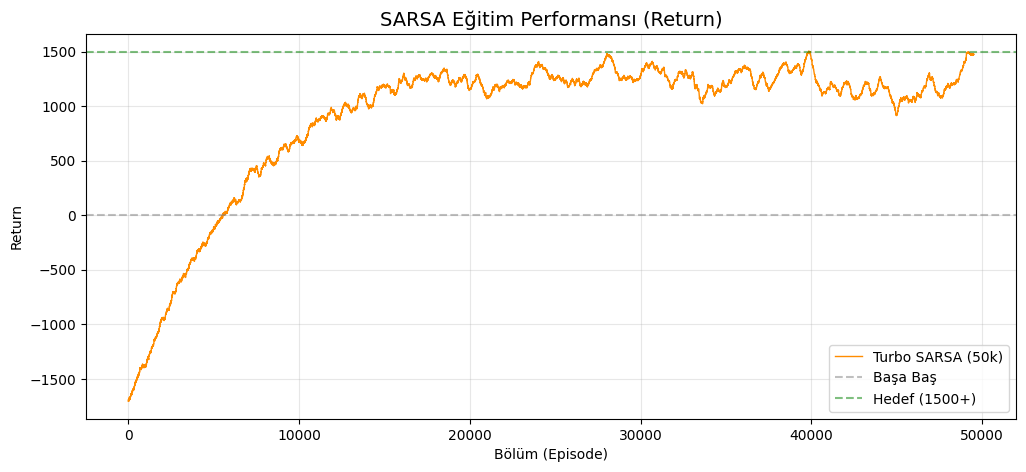


🤖 DETAYLI SİMÜLASYON BAŞLIYOR (50 Adım)

⏱️  ADIM 1 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [CPU] | Boyut: 63 br | Süre: 154.8sn | ⚠️ NORMAL
   👉 SEÇİM:      [CPU] Sunucu 16 (ORTA [$$$])
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. (+46 Puan)
----------------------------------------------------------------------

⏱️  ADIM 2 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [CPU] | Boyut: 28 br | Süre: 153.2sn | ☕ RAHAT
   👉 SEÇİM:      [CPU] Sunucu 27 (YAVAŞ [$$])
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. (+95 Puan)
----------------------------------------------------------------------

⏱️  ADIM 3 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [IO] | Boyut: 67 br | Süre: 374.3sn | ☕ RAHAT
   👉 SEÇİM:      [IO] Sunucu 56 (YAVAŞ [¢])
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. (+95 Puan)
----------------------------------------------------------------------

⏱️  ADIM 4 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [CPU] | Boyut: 86 br | Süre: 199.8sn | ⚠️ NORMAL
   👉 SEÇİM:      [CPU]

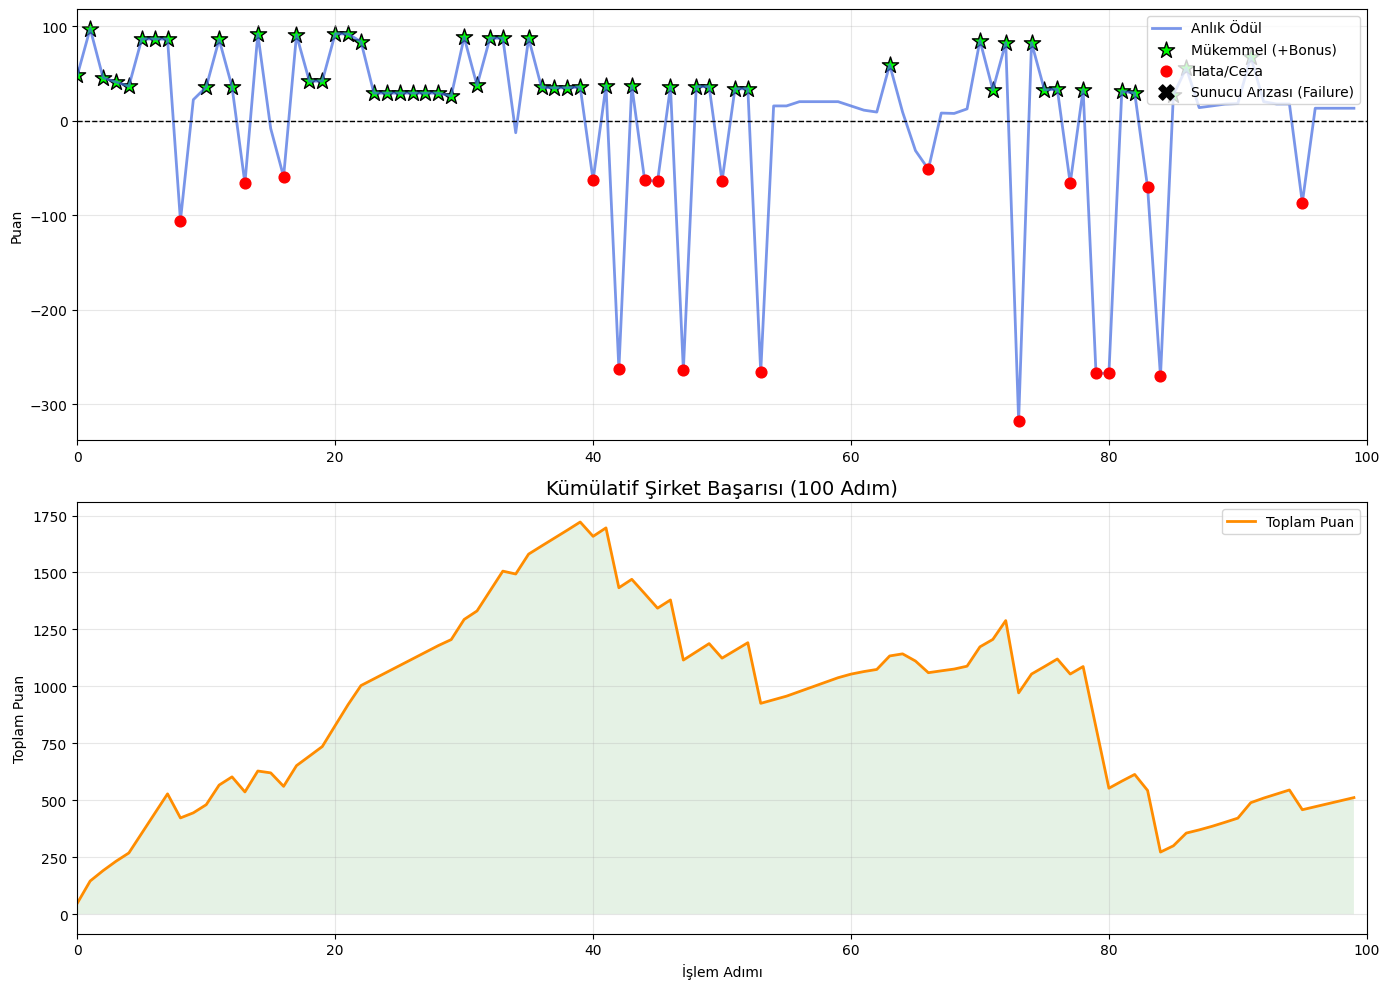

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# ==============================================================================
# 1. ORTAM VE SUNUCU YAPISI (Aynısı Korundu)
# ==============================================================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type
        self.queue = 0
        self.is_down = False
        self.repair_time = 0
        self.speed_tier = speed_tier

        # Hız ve Maliyet Baz Değerleri
        if speed_tier == 0:   # FAST
            base_speed = 5.0
            base_cost = 12.0
        elif speed_tier == 1: # MID
            base_speed = 2.5
            base_cost = 4.0
        else:                 # SLOW
            base_speed = 1.0
            base_cost = 1.0

        # Tipe Göre Çarpanlar (CPU %50 Daha Hızlı ve Pahalı)
        if s_type == "CPU":
            self.process_speed = base_speed * 1.5
            self.energy_cost = base_cost * 1.5
        else:
            self.process_speed = base_speed * 1.0
            self.energy_cost = base_cost * 1.0

    def do_work(self):
        # Arıza Durumu
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0: self.is_down = False
            return 0

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

class OptimizedEnv:
    def __init__(self):
        self.n_servers = 60
        self.servers = []
        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            tier = 0 if (i%30)<10 else (1 if (i%30)<20 else 2)
            self.servers.append(Server(i, s_type, tier))
        self.current_job = self._generate_job()
        self.action_space_n = 60
        self.is_daytime = True

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        size = random.randint(20, 100)
        slack = random.uniform(1.2, 7.0)
        deadline = size / 1.0 * slack
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        j_type = 0 if self.current_job["type"] == "CPU" else 1
        size_bucket = 1 if self.current_job["size"] > 60 else 0
        job_slack = self.current_job["deadline"] / self.current_job["size"]
        if job_slack < 2.0: urgency = 2 # Kritik
        elif job_slack < 4.5: urgency = 1 # Normal
        else: urgency = 0 # Rahat
        price = 1 if self.is_daytime else 0
        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0
        job = self.current_job

        # --- CEZA 1: Bile bile bozuk sunucuya iş atarsa ---
        if target_server.is_down:
            reward -= 50

        # 1. Tahmini Süre ve Bonuslar
        completion_time = (target_server.queue + job["size"]) / target_server.process_speed

        if completion_time <= job["deadline"]:
            reward += 20 # Temel Başarı
            if target_server.speed_tier == 2: reward += 80 # Yavaş Sunucu Bonusu
            elif target_server.speed_tier == 1: reward += 30 # Orta Sunucu Bonusu
        else:
            reward -= 250 # Deadline Kaçırma Cezası

        # 2. İş Ekleme
        target_server.queue += job["size"]

        # --- CEZA 2: Tip Uyuşmazlığı ---
        if target_server.type != job["type"]: reward -= 50

        # 3. Simülasyon (Arıza ve Enerji)
        total_energy = 0
        price_mult = 2.0 if self.is_daytime else 1.0

        for s in self.servers:
            energy = s.do_work()
            total_energy += energy

            # --- CEZA 3: SİSTEMSEL ARIZA (Şanssızlık) ---
            # Olasılık %0.2 (Yüksek Risk)
            if not s.is_down and random.random() < 0.002:
                s.is_down = True
                s.repair_time = 15
                reward -= 100

        # Enerji Maliyeti Düşülüyor
        reward -= (total_energy * price_mult * 0.1)

        if random.random() < 0.05: self.is_daytime = not self.is_daytime
        self.current_job = self._generate_job()

        return self._get_state(), reward, False, {}

# ==============================================================================
# 2. SARSA AJANI
# ==============================================================================
class TurboSarsaAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}
        self.lr = 0.1
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.9999

    def get_q(self, state):
        if state not in self.q_table:
            # Optimistic Initialization
            self.q_table[state] = np.ones(self.action_space) * 100.0
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def update(self, state, action, reward, next_state, next_action):
        # SARSA FORMÜLÜ: next_action kullanılır (max YOK)
        q_current = self.get_q(state)[action]
        q_next = self.get_q(next_state)[next_action] # Doğrudan seçilen eyleme bak

        target = reward + self.gamma * q_next
        self.q_table[state][action] += self.lr * (target - q_current)

# ==============================================================================
# 3. EĞİTİM DÖNGÜSÜ (50.000 BÖLÜM)
# ==============================================================================
print("🚀 SARSA EĞİTİMİ BAŞLIYOR (Zorlu Ortam)...")

EPISODES = 50000

env = OptimizedEnv()
agent = TurboSarsaAgent(env.action_space_n)
rewards = []

start_time = time.time()

for episode in range(EPISODES):
    state = env.reset()
    action = agent.choose_action(state) # İlk adımı başta seç
    total_r = 0

    for _ in range(50): # Her bölüm 50 adım
        next_state, reward, _, _ = env.step(action)
        next_action = agent.choose_action(next_state) # Bir sonraki adımı ŞİMDİ seç

        # SARSA Update
        agent.update(state, action, reward, next_state, next_action)

        state = next_state
        action = next_action # Döngüyü ilerlet
        total_r += reward

    # Epsilon Decay
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
    rewards.append(total_r)

    # LOGLAMA (Her 5000'de bir)
    if (episode+1) % 5000 == 0:
        elapsed = time.time() - start_time
        print(f" -> Bölüm {episode+1}/{EPISODES} Tamamlandı. ({elapsed:.1f} sn) | Return: {total_r:.1f}")

print("\n✅ EĞİTİM TAMAMLANDI!")

# ==============================================================================
# 4. EĞİTİM GRAFİĞİ
# ==============================================================================
print("\n📈 Eğitim Grafiği Çiziliyor...")
window = 500
smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 5))
plt.plot(smoothed_rewards, color='darkorange', linewidth=1, label="Turbo SARSA (50k)")
plt.axhline(0, color='gray', linestyle='--', alpha=0.5, label="Başa Baş")
plt.axhline(1500, color='green', linestyle='--', alpha=0.5, label="Hedef (1500+)")

plt.title("SARSA Eğitim Performansı (Return)", fontsize=14)
plt.xlabel("Bölüm (Episode)")
plt.ylabel("Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==============================================================================
# 5. DETAYLI SİMÜLASYON TESTİ (50 ADIM)
# ==============================================================================
def run_text_simulation(agent, steps=50):
    print(f"\n{'='*70}")
    print(f"🤖 DETAYLI SİMÜLASYON BAŞLIYOR ({steps} Adım)")
    print(f"{'='*70}")

    agent.epsilon = 0 # Sınav Modu
    test_env = OptimizedEnv()
    state = test_env.reset()

    for step in range(1, steps + 1):
        job = test_env.current_job
        slack = job['deadline'] / job['size']

        if slack < 2.0: urgency_icon = "🚨 KRİTİK"
        elif slack < 4.5: urgency_icon = "⚠️ NORMAL"
        else: urgency_icon = "☕ RAHAT"

        time_text = "☀️ GÜNDÜZ (Pahalı)" if test_env.is_daytime else "🌙 GECE (Ucuz)"

        # 1. Bilgileri Yazdır
        print(f"\n⏱️  ADIM {step} | {time_text}")
        print(f"   📦 GELEN İŞ:  [{job['type']}] | Boyut: {job['size']} br | Süre: {job['deadline']:.1f}sn | {urgency_icon}")

        action = agent.choose_action(state)
        server = test_env.servers[action]
        was_down = server.is_down

        # Sunucu Bilgisi Hazırla
        if server.type == "CPU":
            tier_names = {0: "HIZLI [$$$$]", 1: "ORTA [$$$]", 2: "YAVAŞ [$$]"}
        else:
            tier_names = {0: "HIZLI [$$]", 1: "ORTA [$]", 2: "YAVAŞ [¢]"}
        server_desc = tier_names[server.speed_tier]

        # 2. Seçimi Yazdır
        match_text = "✅ UYUMLU" if job['type'] == server.type else "❌ UYUMSUZ"
        print(f"   👉 SEÇİM:      [{server.type}] Sunucu {server.id} ({server_desc})")
        print(f"      ✨ Tip Kontrolü: {match_text}")

        # 3. Adımı Uygula
        next_state, reward, _, _ = test_env.step(action)
        is_down_after = server.is_down

        # 4. Hata ve Sonuç Kontrolü
        if was_down:
            print(f"      🔥 HATA: Ajan zaten BOZUK olan sunucuya iş attı!")
        elif is_down_after and not was_down:
            print(f"      ⚡ ARIZA: Sunucu işlem sırasında patladı!")

        if reward > 0:
            print(f"      ✅ SONUÇ: BAŞARILI. (+{reward:.0f} Puan)")
        else:
            print(f"      ⚠️ SONUÇ: BAŞARISIZ/CEZA. ({reward:.0f} Puan)")

        print("-" * 70)
        state = next_state

# Simülasyonu Çalıştır
run_text_simulation(agent, steps=50)

# ==============================================================================
# 6. GRAFİKLİ TEST KODU (100 ADIM)
# ==============================================================================
def test_and_plot_results(agent, steps=100):
    print(f"\n{'='*60}")
    print(f"📊 GRAFİKLİ TEST BAŞLIYOR ({steps} Adım)...")
    print(f"{'='*60}")

    agent.epsilon = 0
    test_env = OptimizedEnv()
    state = test_env.reset()

    rewards = []
    cumulative_rewards = []
    total_score = 0

    bonus_x, bonus_y = [], []
    penalty_x, penalty_y = [], []
    failure_x, failure_y = [], []

    for step in range(steps):
        action = agent.choose_action(state)
        server = test_env.servers[action]
        was_down = server.is_down

        next_state, reward, _, _ = test_env.step(action)
        is_down_after = server.is_down

        rewards.append(reward)
        total_score += reward
        cumulative_rewards.append(total_score)

        # Olay İşaretleme
        if reward > 25: # Bonus
            bonus_x.append(step)
            bonus_y.append(reward)
        elif reward <= -50: # Ceza
            penalty_x.append(step)
            penalty_y.append(reward)

        if is_down_after and not was_down: # Arıza
            failure_x.append(step)
            failure_y.append(reward)

        state = next_state

    # --- GRAFİK ---
    plt.figure(figsize=(14, 10))

    # Üst Grafik: Anlık Ödüller
    plt.subplot(2, 1, 1)
    plt.plot(rewards, color='royalblue', linewidth=2, label='Anlık Ödül', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    # İşaretleyiciler
    plt.scatter(bonus_x, bonus_y, color='lime', marker='*', s=150, edgecolors='black', label='Mükemmel (+Bonus)')
    plt.scatter(penalty_x, penalty_y, color='red', marker='o', s=60, zorder=5, label='Hata/Ceza')
    plt.scatter(failure_x, failure_y, color='black', marker='X', s=120, label='Sunucu Arızası (Failure)')
    plt.legend(loc='upper right')
    plt.ylabel("Puan")
    plt.grid(True, alpha=0.3)
    plt.xlim(0, steps)

    # Alt Grafik: Kümülatif Başarı
    plt.subplot(2, 1, 2)
    plt.plot(cumulative_rewards, color='darkorange', linewidth=2, label='Toplam Puan')
    plt.fill_between(range(steps), cumulative_rewards, 0, where=(np.array(cumulative_rewards) >= 0), facecolor='green', alpha=0.1)
    plt.fill_between(range(steps), cumulative_rewards, 0, where=(np.array(cumulative_rewards) < 0), facecolor='red', alpha=0.1)
    plt.title(f"Kümülatif Şirket Başarısı ({steps} Adım)", fontsize=14)
    plt.xlabel("İşlem Adımı")
    plt.ylabel("Toplam Puan")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, steps)

    plt.tight_layout()
    plt.show()

# Test Grafiğini Çalıştır
test_and_plot_results(agent, steps=100)